In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

Importing hte MNIST Dataset

In [ ]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


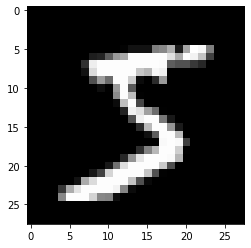

In [ ]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

Here is an example image from the dataset.
The link we are using:

https://pytorch.org/tutorials/beginner/nn_tutorial.html


In [ ]:
# Pytorch uses tensors instead of arrays, need to convert
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [ ]:
# lets first create a neural net from scratch
import math
# Initialize the weights, then set requires gradient( for back propogation)
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_() # Inplace operation
bias  = torch.zeros(10, requires_grad = True)

weights, bias

(tensor([[-0.0322,  0.0099,  0.0794,  ..., -0.0099,  0.0152, -0.0367],
         [-0.0054, -0.0047,  0.0598,  ..., -0.0053, -0.0036, -0.0309],
         [-0.0465,  0.0022,  0.0163,  ..., -0.0477, -0.0429,  0.0450],
         ...,
         [ 0.0436, -0.0007, -0.0070,  ..., -0.0268,  0.0167, -0.0257],
         [ 0.0090, -0.0108, -0.0142,  ...,  0.0289, -0.0250, -0.0330],
         [ 0.0624,  0.0381,  0.0823,  ..., -0.0139, -0.0078, -0.0100]],
        requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))

In [ ]:
# Create a simple model and loss function
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias) # @ indicates matrix mulitplication

In [ ]:
 # Create a batch

 bs  = 64
 xb = x_train[0:bs] # Pick 64 images
 preds = model(xb) # Create predictions
 preds[0], preds.shape

(tensor([-2.6597, -2.9534, -2.1368, -2.2883, -1.9389, -2.0847, -2.2356, -2.2323,
         -2.2617, -2.6337], grad_fn=<SelectBackward0>), torch.Size([64, 10]))

In [ ]:
# Use the negative log liklihood to compute loss (cross entropy)
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [ ]:
yb = y_train[0:bs] # Get the actual classifications
loss_func(preds, yb) # Computes the loss

tensor(2.3168, grad_fn=<NegBackward0>)

In [ ]:
# Function to compute the accuracy of the model
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [ ]:
accuracy(preds, yb)

tensor(0.1406)

In [ ]:
# We can now run a trainining loop
# 1 - select a mini batch of data
# 2 - use the model to make predictions
# 3 - calculate the loss
# 4 - loss.backward() updatesthe gradients of the model, aka the weights and the bias

from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i] # current input batch
        yb = y_train[start_i:end_i] # current output batch
        pred = model(xb) # Current predictions
        loss = loss_func(pred, yb) # current loss

        loss.backward() # update the weights and the biases
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [ ]:
# Lets see how accurate the model is now
accuracy(model(xb), yb)

tensor(1.)

In [ ]:
# Lets refactor the code, but use the torch.nn framework

# This will make the code: shorter, easier to understand, and more flexible

import torch.nn.functional as F

loss_func = F.cross_entropy # the loss function

def model(xb):
  return xb @ weights + bias # matrix multiplcation

In [ ]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0785, grad_fn=<NllLossBackward0>), tensor(1.))

In [ ]:
from torch import nn

class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights  = nn.Parameter(torch.randn(784, 10) / math.sqrt(784)) # assign the initial weights of the model
    self.bias = nn.Parameter(torch.zeros(10))

  def forward(self, xb):
    return xb @ self.weights + self.bias # Compute the simple nn forward
model = Mnist_Logistic()


In [ ]:
loss_func(model(xb), yb)

tensor(2.4028, grad_fn=<NllLossBackward0>)

In [ ]:
# Create a fit function
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [ ]:
loss_func(model(xb), yb)

tensor(0.0834, grad_fn=<NllLossBackward0>)

In [ ]:
# Lets refactor agan, using nn.Linear

class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin = nn.Linear(784, 10) # Creates linear layer
  def forward(self, xb):
    return self.lin(xb) # presto, matrix calculation again

In [ ]:
model = Mnist_Logistic()
loss_func(model(xb), yb)

tensor(2.2637, grad_fn=<NllLossBackward0>)

In [ ]:
fit()
loss_func(model(xb), yb)

tensor(0.0811, grad_fn=<NllLossBackward0>)

In [ ]:
# Refactor the propogration process again
from torch import optim
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr) # Create an optimizer, passing in model and learning rate

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3220, grad_fn=<NllLossBackward0>)
tensor(0.0806, grad_fn=<NllLossBackward0>)


In [ ]:
from torch.utils.data import TensorDataset

In [ ]:
# Can combine X_train, y_train into a single dataset

train_ds = TensorDataset(x_train, y_train)
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0814, grad_fn=<NllLossBackward0>)


 /

/

/

/

/

//////////// Done with Experimentation: Here is the work for problem 5 /////////////

In [ ]:
# Dataset and Dataloader make the algorithm much simpler
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.MNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

In [ ]:
# data loader helps partition the dataset into batches

from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size = 100, shuffle = True)
trest_dataloader = DataLoader(test_data, batch_size = 100, shuffle = True)

In [ ]:
# Two layer neural net using nn.Module
import torch.nn as nn
import torch.nn.functional as F
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
    self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
    # fully connected layer, output 10 classes
    self.out = nn.Linear(32 * 7 * 7, 10)
  def forward(self, x):
    x = F.relu(self.conv1(x)) # perform the convolution, then the activation function on the layer
    x = F.relu(self.conv2(x))

    # Flatten the out
    x= x.view(x.size(0), -1)
    output = self.out(x)
    return output


In [ ]:
model = Model()
loss_func = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

In [ ]:
def train(dataloader, model, loss_func, optimizer):
  size = len(dataloader.dataset)
  model.train()

  # Train the model on every batch; perform forward then backward
  for batch, (X, y) in enumerate(dataloader):
    #X, y = X.to(device), y.to(device) # ??

    # Compute the prediction error
    pred = model(X)
    loss = loss_func(pred, y)
 
    # Clear the previous gradients
    optimizer.zero_grad()

    # computes graidents
    loss.backward()

    # Applies gradients
    optimizer.step()

    # Every 100 batches, print the loss
    if batch % 100 == 0:
        loss, current_batch = loss.item(), batch * len(X)
        print("For the batch " + str(current_batch) + " the loss is " + str(loss))

In [ ]:
train(train_dataloader, model, loss_func, optimizer)

For the batch 0 the loss is 2.310359001159668
For the batch 10000 the loss is 2.2853307723999023
For the batch 20000 the loss is 2.2655158042907715
For the batch 30000 the loss is 2.243856430053711
For the batch 40000 the loss is 2.2306816577911377
For the batch 50000 the loss is 2.195636749267578


In [ ]:
# Lets try again with a differeent optimizer
optimizer2 = optim.Adam(model.parameters(), lr = 0.01)
train(train_dataloader, model, loss_func, optimizer)
for i in range(5):
  train(train_dataloader, model, loss_func, optimizer)

For the batch 0 the loss is 0.438822478055954
For the batch 10000 the loss is 0.2501527965068817
For the batch 20000 the loss is 0.3698313236236572
For the batch 30000 the loss is 0.31150364875793457
For the batch 40000 the loss is 0.22245045006275177
For the batch 50000 the loss is 0.25717222690582275
For the batch 0 the loss is 0.3834066092967987
For the batch 10000 the loss is 0.36567923426628113
For the batch 20000 the loss is 0.40264004468917847
For the batch 30000 the loss is 0.219085693359375
For the batch 40000 the loss is 0.36899739503860474
For the batch 50000 the loss is 0.2682541608810425
For the batch 0 the loss is 0.26861655712127686
For the batch 10000 the loss is 0.24706143140792847
For the batch 20000 the loss is 0.2613620460033417
For the batch 30000 the loss is 0.3429142236709595
For the batch 40000 the loss is 0.2476826161146164
For the batch 50000 the loss is 0.3573053479194641
For the batch 0 the loss is 0.17889125645160675
For the batch 10000 the loss is 0.298407

In [ ]:
# Determine the accuracy of the neural net
def test(dataloader, model, loss_func):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval() 
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      pred = model(X)
      test_loss += loss_func(pred, y).item() # Add the loss amount
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                   
  test_loss /= num_batches
  correct /= size
  print("The test error: ")
  print("\t Accuracy: ", 100 * correct)
  print("\t Avg Loss: ", test_loss)

In [ ]:
test(train_dataloader, model, loss_func)

The test error: 
	 Accuracy:  92.2
	 Avg Loss:  0.2689057399208347


Here is the performance running the CNN on MNIST many times, using a SGD optimizer

In [ ]:
# Try repeating with the adam
# Lets try again with a differeent optimizer

model = Model()
optimizer2 = optim.Adam(model.parameters(), lr = 0.001)
for i in range(5):
  train(train_dataloader, model, loss_func, optimizer2)
test(train_dataloader, model, loss_func)

For the batch 0 the loss is 2.3051483631134033
For the batch 10000 the loss is 0.18956734240055084
For the batch 20000 the loss is 0.13590861856937408
For the batch 30000 the loss is 0.1105237677693367
For the batch 40000 the loss is 0.10080530494451523
For the batch 50000 the loss is 0.030715016648173332
For the batch 0 the loss is 0.023775439709424973
For the batch 10000 the loss is 0.04209733381867409
For the batch 20000 the loss is 0.045487333089113235
For the batch 30000 the loss is 0.10693678259849548
For the batch 40000 the loss is 0.020700059831142426
For the batch 50000 the loss is 0.08158788830041885
For the batch 0 the loss is 0.10063817352056503
For the batch 10000 the loss is 0.03825485333800316
For the batch 20000 the loss is 0.038078926503658295
For the batch 30000 the loss is 0.07640007138252258
For the batch 40000 the loss is 0.02452344447374344
For the batch 50000 the loss is 0.01141931489109993
For the batch 0 the loss is 0.03381400927901268
For the batch 10000 the l